In [1]:
import pandas as pd
import os
import numpy as np
import cv2
import json
import glob
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score

In [2]:
#open manual annotated image from geojson (exported qupath image as geojason because paquo installation failed)
src = r'\\fatherserverdw\Q\research\images\skin_aging\hovernet_tile\hovernet_manual_validation'
manual = os.path.join(src,'manual_annotation')
predicted = os.path.join(src,'predicted_nuclei_contour')
raw_ims = os.path.join(src,'raw_image')

In [9]:
#open manual annotations with json.load
annotations = glob.glob(os.path.join(manual,'*.geojson'))
annotation = annotations[1]
with open(annotation) as f:
  features = json.load(f)["features"]

In [11]:
#create a list of manual contours
man_coordinates = [np.squeeze(_['geometry']['coordinates']) for _ in features]

In [23]:
manual_df = pd.DataFrame({'contour':man_coordinates})
manual_df

,contour
0,"[[368, 427], [368, 428], [367, 428], [366, 429..."
1,"[[242, 339], [241, 340], [239, 340], [238, 341..."
2,"[[168, 364], [167, 365], [166, 365], [166, 366..."
3,"[[322, 384], [321, 385], [320, 385], [319, 386..."
4,"[[387, 334], [387, 335], [386, 335], [386, 336..."
...,...
379,"[[230.0, 311.0], [230.0, 313.0], [233.0, 313.0..."
380,"[[370, 314], [370, 315], [369, 315], [369, 317..."
381,"[[959.0, 403.0], [959.0, 404.0], [957.0, 404.0..."
382,"[[543, 354], [543, 355], [542, 355], [542, 356..."


In [60]:
def contour2centroid(c):
    M = cv2.moments(c)
    cX = int(M["m10"] / M["m00"])
    cY = int(M["m01"] / M["m00"])
    return np.array([cX,cY])

In [61]:
manual_df['centroid']=manual_df['contour'].apply(lambda row:contour2centroid(row))
manual_df

,contour,centroid
0,"[[368, 427], [368, 428], [367, 428], [366, 429...","[369, 439]"
1,"[[242, 339], [241, 340], [239, 340], [238, 341...","[242, 346]"
2,"[[168, 364], [167, 365], [166, 365], [166, 366...","[173, 372]"
3,"[[322, 384], [321, 385], [320, 385], [319, 386...","[326, 392]"
4,"[[387, 334], [387, 335], [386, 335], [386, 336...","[390, 343]"
...,...,...
379,"[[230.0, 311.0], [230.0, 313.0], [233.0, 313.0...","[0, 10]"
380,"[[370, 314], [370, 315], [369, 315], [369, 317...","[391, 322]"
381,"[[959.0, 403.0], [959.0, 404.0], [957.0, 404.0...","[0, 38]"
382,"[[543, 354], [543, 355], [542, 355], [542, 356...","[548, 361]"


In [10]:
#open prediction
pd_annotations = glob.glob(os.path.join(predicted,'*.json'))
#open tile11
pd_annotation = pd_annotations[0]
with open(pd_annotation) as pd_f:
  #bbox, centroid, contour
  pd_features = json.load(pd_f)["nuc"]

In [40]:
#create a list of predicted contours
pd_contours=[]
pd_centroids = []
for key in pd_features:
    temp = pd_features.get(key)
    pd_contours.append(np.array(temp.get('contour')))
    pd_centroids.append(np.round(temp.get('centroid'),0).astype('int'))

In [41]:
predicted_df = pd.DataFrame({'contour':pd_contours,'centroid':pd_centroids})
predicted_df

,contour,centroid
0,"[[667, 300], [666, 301], [666, 302], [667, 301...","[690, 305]"
1,"[[615, 306], [614, 307], [611, 307], [610, 308...","[612, 315]"
2,"[[517, 309], [516, 310], [513, 310], [513, 311...","[522, 318]"
3,"[[675, 310], [674, 311], [673, 311], [672, 312...","[679, 318]"
4,"[[503, 311], [501, 313], [499, 313], [497, 315...","[502, 318]"
...,...,...
342,"[[310, 921], [310, 922], [309, 923], [307, 923...","[310, 927]"
343,"[[698, 930], [698, 931], [697, 932], [698, 933...","[704, 938]"
344,"[[206, 942], [205, 943], [204, 943], [203, 944...","[206, 945]"
345,"[[331, 951], [327, 955], [327, 956], [326, 957...","[331, 958]"


In [5]:
#get size of origianl image
raw = glob.glob(os.path.join(raw_ims,'*.tif'))
raw_img = cv2.imread(raw[0])
dim = raw_img.shape
image_size = (dim[0],dim[1])

In [88]:
#Link ground truth to predicted nuclei
from sklearn.neighbors import NearestNeighbors
manual_centroid= np.array(manual_df['centroid'].values.tolist())
predicted_centroid= np.array(predicted_df['centroid'].values.tolist())
nbrs = NearestNeighbors(n_neighbors=1, metric='euclidean').fit(predicted_centroid) #build model
distances, indices = nbrs.kneighbors(manual_centroid) #apply model
indices=np.squeeze(indices)

In [103]:
predicted_df2 = predicted_df.iloc[indices]
predicted_df2

,contour,centroid
104,"[[369, 428], [367, 430], [367, 431], [366, 432...","[370, 439]"
22,"[[242, 338], [241, 339], [239, 339], [238, 340...","[242, 346]"
33,"[[172, 363], [171, 364], [169, 364], [168, 365...","[173, 372]"
57,"[[321, 384], [320, 385], [319, 385], [316, 388...","[325, 392]"
20,"[[391, 334], [390, 335], [388, 335], [387, 336...","[390, 343]"
...,...,...
18,"[[170, 328], [169, 329], [167, 329], [167, 330...","[181, 337]"
6,"[[360, 314], [359, 315], [357, 315], [356, 316...","[377, 320]"
18,"[[170, 328], [169, 329], [167, 329], [167, 330...","[181, 337]"
26,"[[545, 354], [544, 355], [542, 355], [540, 357...","[549, 361]"


In [111]:
linked_df = manual_df
linked_df['pred_contour'] =predicted_df2.contour.reset_index(drop=True)
linked_df['pred_centroid'] =predicted_df2.centroid.reset_index(drop=True)
linked_df

,contour,centroid,pred_contour,pred_centroid
0,"[[368, 427], [368, 428], [367, 428], [366, 429...","[369, 439]","[[369, 428], [367, 430], [367, 431], [366, 432...","[370, 439]"
1,"[[242, 339], [241, 340], [239, 340], [238, 341...","[242, 346]","[[242, 338], [241, 339], [239, 339], [238, 340...","[242, 346]"
2,"[[168, 364], [167, 365], [166, 365], [166, 366...","[173, 372]","[[172, 363], [171, 364], [169, 364], [168, 365...","[173, 372]"
3,"[[322, 384], [321, 385], [320, 385], [319, 386...","[326, 392]","[[321, 384], [320, 385], [319, 385], [316, 388...","[325, 392]"
4,"[[387, 334], [387, 335], [386, 335], [386, 336...","[390, 343]","[[391, 334], [390, 335], [388, 335], [387, 336...","[390, 343]"
...,...,...,...,...
379,"[[230.0, 311.0], [230.0, 313.0], [233.0, 313.0...","[0, 10]","[[170, 328], [169, 329], [167, 329], [167, 330...","[181, 337]"
380,"[[370, 314], [370, 315], [369, 315], [369, 317...","[391, 322]","[[360, 314], [359, 315], [357, 315], [356, 316...","[377, 320]"
381,"[[959.0, 403.0], [959.0, 404.0], [957.0, 404.0...","[0, 38]","[[170, 328], [169, 329], [167, 329], [167, 330...","[181, 337]"
382,"[[543, 354], [543, 355], [542, 355], [542, 356...","[548, 361]","[[545, 354], [544, 355], [542, 355], [540, 357...","[549, 361]"


In [134]:
# manual cooridnates to labeled mask
groundtruth_mask = np.zeros(image_size)
predicted_mask = np.zeros(image_size)

for index, row in linked_df.iterrows():
    groundtruth_mask = cv2.fillPoly(groundtruth_mask, pts=[np.array(row['contour']).astype(np.int32)],  color=index+1)
    predicted_mask = cv2.fillPoly(predicted_mask, pts=[np.array(row['pred_contour']).astype(np.int32)],  color=index+1)

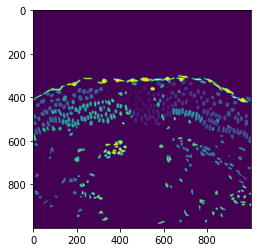

In [135]:
plt.imshow(groundtruth_mask)

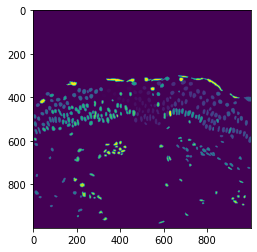

In [136]:
plt.imshow(predicted_mask)

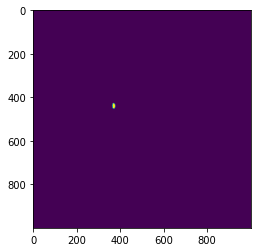

In [137]:
plt.imshow(groundtruth_mask==1)

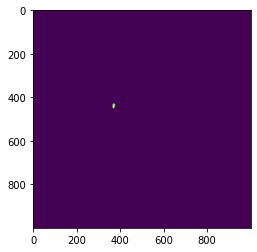

In [138]:
plt.imshow(predicted_mask==1)

In [139]:
jaccard_score(groundtruth_mask==1,predicted_mask==1, average="micro")

0.7769230769230769

In [141]:
scores=[]
for label in range(1,round(np.max(groundtruth_mask))+1):
    scores.append(jaccard_score(groundtruth_mask==label,predicted_mask==label, average="micro"))

In [143]:
linked_df['jaccard_score']=scores
linked_df #Look into why some cells have low score when centroids actually match

,contour,centroid,pred_contour,pred_centroid,jaccard_score
0,"[[368, 427], [368, 428], [367, 428], [366, 429...","[369, 439]","[[369, 428], [367, 430], [367, 431], [366, 432...","[370, 439]",0.776923
1,"[[242, 339], [241, 340], [239, 340], [238, 341...","[242, 346]","[[242, 338], [241, 339], [239, 339], [238, 340...","[242, 346]",0.890152
2,"[[168, 364], [167, 365], [166, 365], [166, 366...","[173, 372]","[[172, 363], [171, 364], [169, 364], [168, 365...","[173, 372]",0.854305
3,"[[322, 384], [321, 385], [320, 385], [319, 386...","[326, 392]","[[321, 384], [320, 385], [319, 385], [316, 388...","[325, 392]",0.815873
4,"[[387, 334], [387, 335], [386, 335], [386, 336...","[390, 343]","[[391, 334], [390, 335], [388, 335], [387, 336...","[390, 343]",0.821429
...,...,...,...,...,...
379,"[[230.0, 311.0], [230.0, 313.0], [233.0, 313.0...","[0, 10]","[[170, 328], [169, 329], [167, 329], [167, 330...","[181, 337]",0.000000
380,"[[370, 314], [370, 315], [369, 315], [369, 317...","[391, 322]","[[360, 314], [359, 315], [357, 315], [356, 316...","[377, 320]",0.541069
381,"[[959.0, 403.0], [959.0, 404.0], [957.0, 404.0...","[0, 38]","[[170, 328], [169, 329], [167, 329], [167, 330...","[181, 337]",0.000000
382,"[[543, 354], [543, 355], [542, 355], [542, 356...","[548, 361]","[[545, 354], [544, 355], [542, 355], [540, 357...","[549, 361]",0.890977
